<a href="https://colab.research.google.com/github/harperd/machine-learning/blob/master/notebooks/multiclass-logistic-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Logistic Regression

Use logistic regression to recognize hand-written digits (0 to 9).

## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import scipy.optimize as opt
import google.colab as colab
import io

from scipy.io import loadmat

# Allow saving our graphs in the notebook
%matplotlib inline

Chart Dark Theme For Google Colab Dark Mode

In [0]:
style.use('dark_background')

## Read Sample Data

In [3]:
mat_file = colab.files.upload()
!ls -l

Saving ex3data1.mat to ex3data1.mat
total 7340
-rw-r--r-- 1 root root 7511764 Jul 31 22:24 ex3data1.mat
drwxr-xr-x 1 root root    4096 Jul 19 16:14 sample_data


In [4]:
mat_data = loadmat('ex3data1.mat')
mat_data

{'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [71]:
X = mat_data['X']
y = mat_data['y']
theta = np.zeros(X.shape[1])

print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')
print(f'Theta Shape: {theta.shape}')

X Shape: (5000, 400)
y Shape: (5000, 1)
Theta Shape: (400,)


![Hand written numbers](https://github.com/harperd/machine-learning/blob/master/images/ex3-1.png?raw=1)

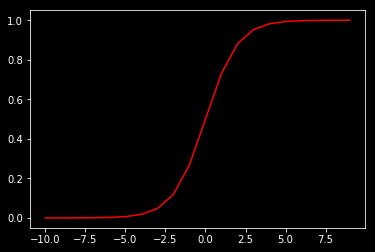

In [41]:
def sigmoid(z):
  return 1 / ( 1 + np.exp(-z) )

nums = np.arange(-10, 10, step = 1)

fig, ax = plt.subplots()
ax.plot(nums, sigmoid(nums), 'r')

plt.show()

In [0]:
def compute_hypothesis(theta, X):
  # Compute our hypothesis
  z = X @ theta.T

  # Scale our hypothesis using Sigmoid
  # Here, if the parameter is zero then the sigmoid value will be 0.5.
  h = sigmoid(z)
  
  return h

In [75]:
def compute_cost(theta, X, y):
  # Fix for minimize function
  theta = np.array(theta, ndmin = 2)
  X = np.array(X, ndmin = 2)
  y = np.array(y, ndmin = 2)

  # Compute our hypothesis
  h = compute_hypothesis(theta, X)
    
  first = np.log(h) * -y
  second = np.log(1 - h) * (1 - y)

  # The number of examples
  m = len(y)
  
  return np.sum(first - second) / m

cost = compute_cost(theta, X, y)
print(f'Cost = {cost}')

Cost = -17.051420641774662


In [79]:
def compute_gradient(theta, X, y):
  # Fix for minimize function
  theta = np.array(theta, ndmin = 2)
  X = np.array(X, ndmin = 2)
  y = np.array(y, ndmin = 2)
  
  # Compute our hypothesis
  h = compute_hypothesis(theta, X)
    
  # Get the error
  error = h - y

  # The number of examples
  m = len(y)

  # Calculate the gradient
  gradient = ( error.T @ X ) / m

  return gradient
  
compute_gradient(theta, X, y)

array([[ 0.00000000e+00,  0.00000000e+00, -7.74530186e-08,
         3.19876600e-06,  1.89536237e-05, -7.06376094e-04,
        -8.97395355e-04, -3.72741263e-04, -1.10787541e-04,
        -1.37049401e-04, -4.11905416e-05,  3.09307938e-05,
         7.56273049e-05,  1.66101324e-04,  1.88959823e-04,
         1.11618541e-04,  3.44740605e-05,  2.31849497e-07,
        -3.65944989e-07,  0.00000000e+00, -2.71480120e-07,
         2.68348312e-06,  1.35802658e-06,  5.10971729e-05,
         9.29459372e-05, -1.13518367e-03, -4.04630781e-03,
        -5.65616107e-03, -4.38249876e-03, -1.22936584e-03,
         1.06402725e-03,  1.67724463e-03,  1.83122226e-03,
         1.41359436e-03,  1.00669534e-03,  6.22600175e-04,
         2.88468971e-04,  1.69300222e-04,  4.53328568e-05,
         1.64277642e-05,  2.32894093e-06, -2.61429416e-05,
         6.07579192e-05, -2.68789968e-04, -2.19152610e-03,
        -1.11673884e-02, -2.41869621e-02, -3.12963830e-02,
        -2.35164217e-02, -1.04915336e-02, -4.58342103e-0